In [2]:
import numpy as np
from matplotlib    import pyplot as plt
from numpy.random  import default_rng
from tqdm          import tqdm
from time          import perf_counter 
from scipy.stats   import pearsonr, poisson, wishart, multivariate_normal, norm, vonmises, multivariate_t, laplace
from scipy.special import gamma, factorial, gammaln
from scipy.special import i0 as I0
from dw_tools      import bivariate_tools

In [3]:
%autosave 300
%load_ext autoreload
%autoreload 2

Autosaving every 300 seconds


In [4]:
plt.rcParams.update({'font.size': 14})

## Joint probability distributions of $(E_1,E_2,E_3)$

Consider three normalized structure factors for related structures, $\left(E_1, E_2, E_3=E_{ref}\right)$ with joint probability density. In the (double) Wilson model,

$$
P\left(E_1,E_2,E_3\right) = P\left(E_{1x},E_{2x},E_{3x},E_{1y},E_{2y},E_{3y}\right)=N\left(0,C\right)
$$

(note the rearrangement of rows), with 

$$
C = \frac{1}{2}
\begin{bmatrix}
1   & r_x & r & 0   & 0   & 0  \\
r_x & 1   & r & 0   & 0   & 0  \\
r   & r   & 1 & 0   & 0   & 0  \\
0   & 0   & 0 & 1   & r_x & r  \\
0   & 0   & 0 & r_x & 1   & r  \\
0   & 0   & 0 & r   & r   & 1  
\end{bmatrix}
$$

## Conditional joint probability distribution of $(E_1, E_2)$ given $E_3$

### General considerations
Following https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions, 

$$
P\left(E_1,E_2 | E_3\right) = P\left(E_{1x},E_{2x},E_{1y},E_{2x}|E_{3x}, E_{3y}\right)=N\left(r E_3,C_{1,2|3}\right)
$$

(note the rearrangement of rows), with conditional covariance matrix

$$
C_{1,2|3} = \frac{1}{2}
\begin{bmatrix}
1   -r^2 & r_x -r^2 & 0       & 0        \\
r_x -r^2 & 1   -r^2 & 0       & 0        \\
0        & 0        & 1  -r^2 & r_x -r^2 \\
0        & 0        & r_x-r^2 & 1 -r^2  
\end{bmatrix}
$$

Note that $r$ and $r_x$ cannot adopt arbitrary combinations of values. Specifically, the conditional covariance matrix is only positive definite if $1+r_x \geq 2r^2$. $E_1$ and $E_2$ are conditionally independent (and uncorrelated) when $r_x = r^2$. In that case, $1+r_x = 1+r^2 \geq 2r^2 $.

For use of the bivariate Rice distribution below, we will also want to know 

$$
\begin{align}
\rho\left(E_1,E_2|E_3\right) & = \frac{\mathbb{E}(E_1 E_2^*)-\mathbb{E}(E_1)\mathbb{E}(E_2^*)}
                                    {\sqrt{Var(E_1)Var(E_2)}} \\
                             & = \frac{\mathbb{E}\left((E_1-\mu_{1|3}+\mu_{1|3}) (E_2-\mu_{2|3}+\mu_{2|3})^*\right)
                                       -\mathbb{E}(E_1)\mathbb{E}(E_2^*)}
                                    {\sqrt{Var(E_1)Var(E_2)}} \\
                             & = \frac{Cov(E_1, E_2^*)+\mu\mu^*-\mu\mu^*}
                                    {\sqrt{Var(E_1)Var(E_2)}} \\
                             & = \frac{Cov(E_{1x}, E_{2x}) + Cov(E_{1y}, E_{2y})+0}{\sqrt{Var(E_1)Var(E_2)}} \\
                             & = \frac{r_x-r^2}{1-r^2}
\end{align}
$$

with the variances analogously defined as $Var(E_1)=\mathbb{E}(E_1 E_1^*)-\mathbb{E}(E_1)\mathbb{E}(E_1^*)$, etc.

In [5]:
def rho_xy(r,rx):
    return (rx-r**2)/(1-r**2)
print(rho_xy(0.8,0.9))

0.7222222222222222


Numerical check:

In [6]:
rng = default_rng()
r   = 0.8
rx  = 0.9
mean= np.asarray([1.5,1.5,0,0])
cov = 0.5*\
    np.asarray([[ 1-r**2, rx-r**2,0,      0      ],\
                [rx-r**2,  1-r**2,0,      0      ],\
                [0,        0,     1-r**2, rx-r**2],\
                [0,        0,    rx-r**2,  1-r**2]])
vals = rng.multivariate_normal(mean,cov,1000000)

# see the extended version of this notebook:
# x=np.sqrt(vals[:,0]**2 + vals[:,2]**2)
# y=np.sqrt(vals[:,1]**2 + vals[:,3]**2)
# print(f"expected rho(x2,y2): {rho_x2y2(r,rx,np.array(mean[[0,2]]))}")
# print(f"observed rho(x2,y2): {pearsonr(x**2,y**2)[0]}")

cov_1_2 = np.cov(vals[:,0],vals[:,1]) + np.cov(vals[:,2],vals[:,3])
var_1_1 = np.var(vals[:,0]) + np.var(vals[:,2])
var_2_2 = np.var(vals[:,1]) + np.var(vals[:,3])
print(f"expected rho(x, y):  {rho_xy(r,rx)}")
print(f"observed rho(x, y):  {cov_1_2[0,1]/np.sqrt(var_1_1*var_2_2)}") #I should improve the variable names

expected rho(x, y):  0.7222222222222222
observed rho(x, y):  0.721979402808936


## Bivariate rician (Abu-Dayya & Beaulieu; Beaulieu & Hemachandra)

**First, we'll consider briefly the derivation of the univariate Rice distribution**.

Consider, again, a pair of variables $\left(E_1, E_{3}\right)$, with $E_1=(E_{1x}, E_{1y})$, and $E_{3}=(E_{3x}, E_{3y})$ jointly normal, $\sim N\left((0,0,0,0),C\right)$, with 

$$
C = 
\frac{\Sigma}{2}
\begin{bmatrix}
1 & 0 & r & 0 \\
0 & 1 & 0 & r \\
r & 0 & 1 & 0 \\
0 & r & 0 & 1  
\end{bmatrix}
$$

The notation is such that $\left<|E_1|^2\right>=\left<E_{1x}^2+E_{1y}^2\right>=\Sigma$. For already normalized structure factors, rather than $F$'s, $\Sigma=1$.

Now, when we have a known value for $E_3=(E_{3,x}, E_{3,y})$, the conditional distribution of $E$ becomes a bivariate normal with mean $\mu = r E_{3}$, with $r$ playing the role of $r_{DW}$ in the double-wilson model, and covariance matrix 

$$C_{1|3} = \frac{\Sigma}{2}
\begin{bmatrix}
1-r^2 & 0 \\
0 & 1-r^2
\end{bmatrix}
$$

It is helpful to write this in polar coordinates using $E_1 = R_1 \left(\cos(\phi_1),\sin(\phi_1)\right)$ and $\mu = r E_3 = R_3 \left(\cos(\phi_3),\sin(\phi_3)\right)$, such that

$$
\begin{align}
P\left(R_1,\phi_1 | R_3, \phi_3\right) & =  R_1 \frac{1}{2 \pi \sqrt{\det(C_{1|3})}} * 
                                       \exp\left(
                                           -\frac{1}{2}
                                           \left(R_1\cos(\phi_1)-R_3\cos(\phi_3), 
                                                 R_1\sin(\phi_1)-R_3\sin(\phi_3)
                                           \right)
                                           C_{1|3}^{-1}
                                           \left(R_1\cos(\phi_1)-R_3\cos(\phi_3), 
                                                 R_1\sin(\phi_1)-R_3\sin(\phi_3)
                                           \right)^T
                                       \right)\\
                                       & = 
                                       R_1 \frac{1}{2 \pi \sqrt{\det(C_{1|3})}} * 
                                       \exp\left(
                                           -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                           +\frac{R_1 R_3 (\cos(\phi_1)\cos(\phi_3)-
                                                                      \sin(\phi_1)\sin(\phi_3))}
                                                            {\Sigma(1-r^2)}          
                                           \right) \\
                                       & = 
                                        \frac{R_1}{\pi \Sigma (1-r^2)}  
                                       \exp\left(
                                           -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                           +\frac{R_1 R_3 \cos(\phi_1-\phi_3)}{\Sigma(1-r^2)}          
                                           \right)
\end{align}                                           
$$

where we use that $C_{1|3}^{-1} = \frac{2}{\Sigma} \frac{1}{1-r^2}$ and $\det(C_{1|3}) = \left(\frac{\Sigma}{2}(1-r^2)\right)^2$.

We can marginalize over $\Delta\phi = \phi_1-\phi_3$,

$$
\begin{align}
P\left(R_1 | R_3\right) & = \int_{0}^{2\pi} d\Delta\phi
                                 \frac{R_1}{\pi \Sigma (1-r^2)} * 
                                 \exp\left(
                                     -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                     +\frac{R_1 R_3 \cos(\Delta\phi)}{\Sigma(1-r^2)}          
                                 \right) \\
                        & = \frac{2 R_1}{\Sigma (1-r^2)} 
                                 \exp\left(
                                     -\frac{R_1^2 + R_3^2}{\Sigma(1-r^2)}
                                 \right)
                            I_0\left(
                                \frac{2 R_1 R_3}{\Sigma(1-r^2)}          
                            \right)
\end{align}                                           
$$

which is the Rice distribution. For comparison to Bricogne (1999), his $R_B$ is our $R_1$, his $r_B$ is our $R_3=r|E_3|$, and his $\Sigma_B$ is $\frac{\Sigma}{2}(1-r^2)$, our per-term conditional variance (I added the $B$ subscripts to indicate "Bricogne").

### Abu-Dayya & Beaulieu, "Switched Diversity in Microcellular Ricean Channels"

The Rice distribution is of interest in the wireless communication literature. The equation above maps to the "Ricean PDF" in eq. 1 of Abu-Dayya and Beaulieu (1994), with $K = R_3^2/\Sigma(1-r^2)$ in our terms, or $R^2/\Sigma$ in Bricogne (1999), eq. 1.6's, and $\frac{1+K}{\beta}=2/\Sigma(1-r^2)$ in our terms, or $1/\Sigma_B$ in Bricogne's. Recall that  $R_3=r|E_3|$. In this formalism,

$$P\left(R_1\right|E_3) = \frac{R_1(1+K)}{\beta}\exp\left(-K-\frac{(1+K)R_1^2}{2\beta}\right)\times 
                                            I_0\left(2R_1\sqrt{\frac{K(1+K)}{2\beta}}\right)
$$                                            

**This formalism is worth studying, because Abu-Dayya and Beaulieu derive a bivariate Rice distribution, with**

$$
\begin{align}
P\left(R_1,R_2 | R_3\right) = & \frac{(1+K)^2 R_1 R_2}{2\pi \beta^2(1-v^2)}
                        \exp\left(
                            \frac{-2K}{1+v} - \frac{(1+K)(R_1^2+R_2^2)}{2(1-v^2)\beta}
                        \right) \\ 
                        & \times
                        \int_{0}^{2\pi} \exp\left(
                            \frac{v(1+K)R_1 R_2 \cos \theta}{(1-v^2)\beta}
                        \right) \\
                        & \times I_0\left(
                            \sqrt{\frac{2K(1+K)(R_1^2 + R_2^2+2R_1R_2\cos\theta}{\beta(1+v)^2}}
                        \right) d\theta
\end{align}
$$

with 

$$
v = \frac{\left<\left(E_1^* - \left<E_1^*\right>\right)\left(E_2 - \left<E_2\right>\right)\right>}
         {\sqrt{
             \left<\left|E_1 - \left<E_1\right>\right|^2\right>
             \left<\left|E_2 - \left<E_2\right>\right|^2\right>       
              }}
$$

For the case of the pdf of $E_1$ and $E_2$ conditional on $E_3$, we derive and validate an expression for $v$ above, namely

$$
v=\frac{r_x-r^2}{1-r^2}
$$

Note that the expression for $v$ is equivalent to the expression for $\rho_{k,j}=\lambda_k \lambda_j$ in Beaulieu & Hemachandra (2011).

We begin by sampling directly from the conditional distribution of $E_1$ and $E_2$ given $E_3$. 

In [7]:
rng = default_rng()
r   = 0.9
rx  = 0.99
Eref = 2
mean= np.asarray([r*Eref, r*Eref, 0, 0]) # conditional mean, equal to r * E3

cov = 0.5*\
    np.asarray([[ 1-r**2, rx-r**2,0,      0      ],\
                [rx-r**2,  1-r**2,0,      0      ],\
                [0,        0,     1-r**2, rx-r**2],\
                [0,        0,    rx-r**2,  1-r**2]])
vals = rng.multivariate_normal(mean,cov,10000000)
R1_sq=vals[:,0]**2 + vals[:,2]**2
R2_sq=vals[:,1]**2 + vals[:,3]**2


Implementing eq. 15 of Abu-Dayya and Beaulieu--see ```bivariate_tools.Bivariate_Rice```

In [24]:
# R3 = np.sqrt(float(mean[0]**2 + mean[2]**2))  # r*E3
E3 = 0.6
R3 = r*E3
K  = R3**2    /(1-r**2)
p1 = 2        /(1-r**2)
v  = (rx-r**2)/(1-r**2)

**I implemented this as follows**

In [25]:
R1=0.2
R2=1.2
print(bivariate_tools.Bivariate_Rice(R1,R2,K,p1,v))
print(bivariate_tools.Bivariate_Rice_wrapper(E1=R1, E2=R2, rx=rx, Sigma=1.0, E3=E3, r=r))

7.335886514453257e-22
7.335886514453257e-22


In [ ]:
nx, ny = (200,200)
xy_max = 6
xbase  = np.linspace(0.001, xy_max, nx)
ybase  = np.linspace(0.001, xy_max, ny)
xx,yy  = np.meshgrid(xbase,ybase)
y_in   = np.transpose(np.array([xx.flatten(), yy.flatten()]))
print(y_in.shape)

t1_start = perf_counter()  
result = np.zeros((nx,ny))
for i in range(nx):
    for j in range(ny):
        result[i,j] = bivariate_tools.Bivariate_Rice(xbase[i],ybase[j],K,p1,v)
t1_end = perf_counter()  

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result[:])*((xy_max/nx)*(xy_max/ny)):.4}")

In [ ]:
(xmax,ymax) = (xy_max,xy_max)
xedges = np.linspace(0,xmax,nx+1)
yedges = np.linspace(0,ymax,ny+1)
Hx_emp, xedges, yedges = np.histogram2d(np.sqrt(R1_sq), np.sqrt(R2_sq), bins=(xedges, yedges),density=True)

plt.figure(figsize=(16,5))                         
plt.subplot(1,3,1)        
plt.imshow(Hx_emp, interpolation='none', extent=[0,xmax,0,ymax],origin='lower')
plt.xlabel(r"x=$\sqrt{E_{1x}^2+E_{1y}^2}$"); plt.ylabel(r"y=$\sqrt{E_{2x}^2+E_{2y}^2}$")
plt.text(1.5,6.2,"Empirical 2D")
plt.colorbar(); 

plt.subplot(1,3,2)        
plt.imshow(result, interpolation='none', extent=[0,xmax,0,ymax],origin='lower')
plt.text(1.5,6.2,"Bivariate Rice")
plt.colorbar()
                         
plt.subplot(1,3,3)
plt.imshow(Hx_emp-result, interpolation='none', extent=[0,xmax,0,ymax],origin='lower',vmin=-0.05,vmax=0.05)
plt.text(1.5,6.2,"Difference")
plt.colorbar(); plt.show()

A look at asymptotic normal approximations

In [ ]:
plt.plot(xbase,np.log((6/200)*np.sum(result,axis=0)),label="Rice (marginal)")
loc=np.sqrt(np.sum(mean[[0,2]]**2))

plt.plot(xbase,np.log(norm.pdf(xbase,loc=loc, scale=0.5)),'r--',label="Normal(0.5,0.5)")
plt.ylabel("log(PDF)")
plt.xlabel("|E_1|")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(R1_sq-R2_sq,100, density=True)
plt.yscale("log")
xl=plt.xlim()
yl=plt.ylim()

x=np.linspace(0.85*xl[0],0.85*xl[1],100)
y1=   norm.pdf(x,0,np.std(R1_sq-R2_sq))
y2=laplace.pdf(x,0,np.std(R1_sq-R2_sq)/np.sqrt(2))

plt.plot(x,y1,'r-')
plt.plot(x,y2,'m-')
plt.ylim(yl)
ref="{ref}"
plt.title(f"$r$={r}, $r_x$={rx}, $E_{ref}$ = {Eref}, std($\Delta F$)={np.std(R1_sq-R2_sq):.2}")
plt.xlabel(r"$\Delta |F|$")
plt.grid()
plt.plot()

## Centric case
Following https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions, 

$$
P\left(E_{1c},E_{2c} | E_{3c}\right) = N\left(r E_{3c},C_{1c|3c}\right)
$$

with 

$$
C_{1c|3c} = 
\begin{bmatrix}
1   -r^2 & r_x -r^2 \\
r_x -r^2 & 1   -r^2         
\end{bmatrix}
$$

We then have that 

$$
P\left(|E_{1c}|,|E_{2c}| | |E_{3c}|\right) = P\left(E_{1c},E_{2c} | E_{3c}\right) + 
                                             P\left(-E_{1c},E_{2c} | E_{3c}\right) +
                                             P\left(E_{1c},-E_{2c} | E_{3c}\right) +
                                             P\left(-E_{1c},-E_{2c} | E_{3c}\right)
$$

There should not be any need to further simplify this.

In [32]:
r   = 0.7
rx  = 0.9
mean= np.asarray([1.5,1.5])
cov = np.asarray([[ 1-r**2, rx-r**2],\
                  [rx-r**2,  1-r**2]])

print(bivariate_tools.FoldedNorm2D_wrapper(3, 2, rx=rx, Sigma=1.0, E3=1.5, r=r))
print(bivariate_tools.FoldedNorm2D(3,2, mean, cov))

0.014525491273855108
0.014525491273855108


[[0.51 0.41]
 [0.41 0.51]]


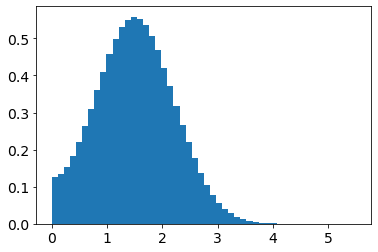

In [33]:
rng = default_rng()

print(cov)
vals = rng.multivariate_normal(mean,cov,10000000)
R1_abs=np.abs(vals[:,0])
R2_abs=np.abs(vals[:,1])

plt.hist(R1_abs,50,density=True)
plt.show()

In [34]:
nx, ny = (100,100)
xy_max = 4
xbase  = np.linspace(0.001, xy_max, nx)
ybase  = np.linspace(0.001, xy_max, ny)
xx,yy  = np.meshgrid(xbase,ybase)
y_in   = np.transpose(np.array([xx.flatten(), yy.flatten()]))
print(y_in.shape)

t1_start = perf_counter()  
result = bivariate_tools.FoldedNorm2D_all(y_in[:,0].reshape(-1,1), y_in[:,1].reshape(-1,1), mean, cov)
result = result.reshape(nx,ny)
print(result.shape)
t1_end = perf_counter()  

print(f"Elapsed time: {t1_end-t1_start:.3} s")
print(f"Integrated probability density: {np.sum(result[:])*((xy_max/nx)*(xy_max/ny)):.3}")

(10000, 2)
[[0.51 0.41]
 [0.41 0.51]]
(100, 100)
Elapsed time: 0.0036 s
Integrated probability density: 0.985


In [ ]:
xedges = np.linspace(0,4,101)
yedges = np.linspace(0,4,101)
Hx_emp, xedges, yedges = np.histogram2d(R1_abs, R2_abs, bins=(xedges, yedges),density=True)

plt.figure(figsize=(16,5))                         
plt.subplot(1,3,1)        
plt.text(1,4.2,"Empirical 2D")
plt.imshow(Hx_emp, interpolation='none', extent=[0,4,0,4],origin='lower')
plt.xlabel(r"x=$|E_1|$"); plt.ylabel(r"y=$|E_2|$")
plt.colorbar(); 

plt.subplot(1,3,2)        
plt.imshow(result, interpolation='none', extent=[0,4,0,4],origin='lower')
plt.text(0.2,4.2,"Bivariate Folded Normal")
plt.colorbar()
                         
plt.subplot(1,3,3)
plt.imshow(Hx_emp-result, interpolation='none', extent=[0,4,0,4],origin='lower',vmin=-0.05,vmax=0.05)
plt.text(1,4.2,"Difference")
plt.colorbar(); plt.show()

## Posterior bivariate phase distributions

In the case where we want infer $E_{on}$ and $E_{off}$ the joint distribution of $\phi_{on}$ and $\phi_{off}$ conditional on $|E_{on}|$ and $|E_{off}|$ seem to always be unimodal with positive correlation between $\phi_{on}$ and $\phi_{off}$.

In [ ]:
rng = default_rng()
r   = 0.8
rx  = 0.9
mean= np.asarray([2,2,0,0])
cov = 0.5*\
    np.asarray([[ 1-r**2, rx-r**2,0,      0      ],\
                [rx-r**2,  1-r**2,0,      0      ],\
                [0,        0,     1-r**2, rx-r**2],\
                [0,        0,    rx-r**2,  1-r**2]])
vals = rng.multivariate_normal(mean,cov,10000000)
phi1= np.angle(vals[:,0] + 1j*vals[:,2])
phi2= np.angle(vals[:,1] + 1j*vals[:,3])
R1_sq=vals[:,0]**2 + vals[:,2]**2
R2_sq=vals[:,1]**2 + vals[:,3]**2

In [ ]:
xedges = np.linspace(-np.pi,np.pi,101)
yedges = np.linspace(-np.pi,np.pi,101)
Hx_emp, xedges, yedges = np.histogram2d(phi1, phi2, bins=(xedges, yedges),density=True)

plt.imshow(Hx_emp, interpolation='none', extent=[-3.142,3.142,-3.142,3.142],origin='lower')
plt.title("2D histogram of phases")
plt.xlabel(r"$\varphi_1$")
plt.ylabel(r"$\varphi_2$")
plt.show()

Looking at conditional distributions given $|E_1|$ and $|E_2|$.  

In [ ]:
sig=0.5
E1 = 3
E2 = 3
phi1_sub = phi1[((R1_sq-E1**2) < sig) & ((R2_sq-E2**2) < sig)]
phi2_sub = phi2[((R1_sq-E1**2) < sig) & ((R2_sq-E2**2) < sig)]

Hx_emp, xedges, yedges = np.histogram2d(phi1_sub, phi2_sub, bins=(xedges, yedges),density=True)

plt.imshow(Hx_emp, interpolation='none', extent=[-3.142,3.142,-3.142,3.142],origin='lower')
plt.show()

### Coppens Model

Considering $E^{gs}$ and $E^{es}$ instead, we'll use the following generative model. Let $(E_{gs,x},E_{es,x},E_{3,x},E_{gs,y},E_{es,y},E_{3,y})$ have the following joint distribution:

$$
(E_{gs,x},E_{es,x},E_{3,x},E_{gs,y},E_{es,y},E_{3,y})\sim N\left(\mu=0,C\right)
$$

with covariance matrix

$$
C = \frac{1}{2}
\begin{bmatrix}
1      & r_x    & r_{gs} & 0      & 0      & 0  \\
r_x    & 1      & r_{es} & 0      & 0      & 0  \\
r_{gs} & r_{es} & 1      & 0      & 0      & 0  \\
0      & 0      & 0      & 1      & r_x    & r_{gs}  \\
0      & 0      & 0      & r_x    & 1      & r_{es}  \\
0      & 0      & 0      & r_{gs} & r_{es} & 1  
\end{bmatrix}
$$

$$
P\left(E_{gs,x},E_{es,x},E_{3,x},E_{gs,y}|E_{es,y},E_{3,y}\right)\sim N\left(\mu=(r_{gs},r_{es})^T E_3,C_{gs,es|3}\right)
$$

with 

$$
C_{gs,es|3} = \frac{1}{2}
\begin{bmatrix}
1-r_{gs}^2          & r_x - r_{gs}r_{es} & 0      & 0  \\
r_x - r_{gs}r_{es}  & 1   - r_{es}^2     & 0      & 0  \\
0                   & 0                  & 1-r_{gs}^2          & r_x - r_{gs}r_{es}  \\
0                   & 0                  & r_x - r_{gs}r_{es}  & 1   - r_{es}^2    
\end{bmatrix}
$$

where we assumed, without loss of generality, that the phase of $E_3$ is zero (so all phases below are really phase differences relative to the phase of $E_3$!). Note that when $r_x=r_{es} \times r_{gs}$, there are no correlations between $E_{gs}$ and $E_{es}$ beyond their joint correlation with the reference data set. 


The next step is to postulate that in our measurements, $E_{off}=E_{gs}$ and $E_{on} = (1-p)E_{gs}+p E_{es}$.

In [ ]:
# for example
p    = 0.3
r_es = 0.9
r_gs = 0.96
rx   = 0.95
E3   = 1.5
# warning: it is possible to specify inconsistent combinations here that yield covariance matrices that are not positive definite

### Simulated data

In [ ]:
rng = default_rng()

mean= np.asarray([r_gs*E3,r_es*E3,0,0])
cov = 0.5*\
    np.asarray([[ 1-r_gs*r_gs, rx -r_es*r_gs, 0,            0      ],\
                [rx-r_es*r_gs,  1 -r_es*r_es,   0,            0      ],\
                [0,           0,              1 -r_gs*r_gs, rx-r_gs*r_es],\
                [0,           0,              rx-r_gs*r_es,  1-r_es*r_es]])
print(cov)
lam,V = np.linalg.eig(cov)
print(lam)
vals   = rng.multivariate_normal(mean,cov,10000000)
E_gs   = vals[:,0] + 1j * vals[:,2]
E_es   = vals[:,1] + 1j * vals[:,3]
E_off  = E_gs
E_on   = (1-p)*E_gs + p*E_es
phi_on = np.angle(E_off)
phi_off= np.angle(E_on)
E_off_abs = np.abs(E_off)
E_on_abs  = np.abs(E_on)

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.hist(E_off_abs,100,density=True); plt.xlim((0,3))
plt.grid(); xl = plt.xlim()
plt.title("Distribution of E_off")

plt.subplot(1,2,2)
plt.hist(E_on_abs,100,density=True); plt.xlim((0,3))
plt.title("Distribution of E_on")
plt.xlim(xl); plt.grid(); plt.show()

In [ ]:
xedges = np.linspace(-np.pi,np.pi,401)
yedges = np.linspace(-np.pi,np.pi,401)
Hx_emp, xedges, yedges = np.histogram2d(phi_on, phi_off, bins=(xedges, yedges),density=True)

lims = 3*np.array([-1,1])
diag = np.pi*np.array([-1.,1.])

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(Hx_emp, interpolation='none', extent=[-3.142,3.142,-3.142,3.142],origin='lower')
plt.plot(diag,diag,'r-')
plt.xlim(lims); plt.ylim(lims); plt.title("Joint phase distribution conditional on E3")

sig= 0.3
E1 = 2
E2 = 2 # try 1.3 or 2.5 for extremes for (p=0.3, r_es=0.9, r_gs=0.95, rx=r_es*r_gs, E3=2)
selection = (np.abs(E_off_abs-E1) < sig) & (np.abs(E_on_abs-E2) < sig)
phi1_sub = phi_on[ selection ]
phi2_sub = phi_off[selection]

plt.subplot(1,2,2)
Hx_emp, xedges, yedges = np.histogram2d(phi1_sub, phi2_sub, bins=(xedges, yedges),density=True)
plt.imshow(Hx_emp, interpolation='none', extent=[-3.142,3.142,-3.142,3.142],origin='lower')
plt.plot(diag,diag,'r-')
plt.xlim(lims); plt.ylim(lims); plt.title("Joint phase distribution conditional on E3 AND |E_on|,|E_off|")
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(phi_on-phi_off,100,density=True); 
plt.title("Distribution of phi_on-phi_off")
plt.grid()

plt.subplot(1,2,2)
plt.hist(phi1_sub-phi2_sub,100,density=True); 
plt.title("Cond. Distribution of phi_on-phi_off")
plt.grid()

plt.show()
print(np.mean(phi1_sub-phi2_sub))

For any realistic scenario above, I always end up with positively correlated phases, a single mode, and mean 0.

### Bivariate torus folded normal (BTFN) & Bivariate torus folded Student _t_ (BVTFST!)
See ```bivariate_tools.py```

### Evaluation and comparison to simulated data

In [ ]:
nx, ny = (1000,1000)
xbase  = np.linspace(-np.pi, np.pi, nx)
ybase  = np.linspace(-np.pi, np.pi, ny)
dx     = (xbase[-1]-xbase[0])/nx
dy     = (ybase[-1]-ybase[0])/ny
xx,yy  = np.meshgrid(xbase,ybase)
y_in   = np.transpose(np.array([xx.flatten(), yy.flatten()]))
print(y_in.shape)

t1_start = perf_counter()  
# result = sin_BVM(y_in,k1=k1,k2=k2,lam=lam,mu=0,nu=0)
# result = cos_pos_BVM(y_in,k1=k1,k2=k2,k3=k3,mu=0,nu=0)
# result = result/(dx*dy*np.sum(result[:]))
tmp=np.cov(phi_off,phi_on)
tmp[1,1]= 0.85*tmp[1,1]
tmp[0,1]=0.932*np.sqrt(tmp[0,0]*tmp[1,1])
tmp[1,0]=0.932*np.sqrt(tmp[0,0]*tmp[1,1])
result = bivariate_tools.BVTFST(y_in,tmp,df=8)
t1_end = perf_counter() 
print(f"time elapsed: {t1_end-t1_start:.4} s.")

In [ ]:
xedges = np.linspace(-np.pi,np.pi,nx+1)
yedges = np.linspace(-np.pi,np.pi,ny+1)
Hx_emp, xedges, yedges = np.histogram2d(phi_on, phi_off, bins=(xedges, yedges),density=True)

lims = 3.14*np.array([-1,1])/2
diag = np.pi*np.array([-1.,1.])

plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.imshow(Hx_emp, interpolation='none', extent=[-3.142,3.142,-3.142,3.142],origin='lower')
plt.plot(diag,diag,'r-')
plt.xlim(lims); plt.ylim(lims); plt.title("Joint phase dist. | E3"); plt.xlabel(r"$\phi_{off}$"); plt.ylabel(r"$\phi_{on}$")
plt.colorbar(); 

plt.subplot(1,3,2)        
plt.imshow(result.reshape(nx,ny), interpolation='none', extent=[-np.pi,np.pi,-np.pi,np.pi],origin='lower')
plt.plot(diag,diag,'r-')
plt.xlim(lims); plt.ylim(lims); plt.colorbar(); plt.xlabel(r"$\phi_{off}$"); plt.ylabel(r"$\phi_{on}$")
                         
plt.subplot(1,3,3)
plt.imshow(Hx_emp-result.reshape(nx,ny), interpolation='none',extent=[-np.pi,np.pi,-np.pi,np.pi],origin='lower')
plt.plot(diag,diag,'r-')
plt.colorbar(); plt.show()

print(np.sum((2*np.pi/nx)*(2*np.pi/ny) * result[:]))

For some parameter combinations, we see that the ON phases vary more widely than the OFF phases, resulting in a steeper-than-1 slope.

In [ ]:
rho=0.9
plt.figure(figsize=(8,6))

k_range  = [0.1,  0.2, 0.5, 1]#,  2,  4,  8]
kp_range = [0.11,  0.2, 0.45, 0.8] #,1.5,3.2,7]
offset_range = np.array([k/30 for k in k_range])
print(offset_range)
for i in range(len(k_range)):
    k  = k_range[ i]
    kp = kp_range[i]
    offset = offset_range[i]
    cov = k*np.array([[1,rho],[rho,1]])
    result = bivariate_tools.BVTFST(y_in,cov,mu=0,nu=0,df=8)
#     result = bivariate_tools.BTFN(y_in,cov,mu=0,nu=0)
#     result = offset/(2*np.pi) + (1-offset)*result
    p = plt.plot(xbase, np.sum((2*np.pi/ny)*result.reshape(nx,ny),axis=1),label=f"k={k}")
    plt.plot(xbase, vonmises.pdf(xbase,kappa=1/kp,loc=0),color=p[0].get_color(),linestyle='dashed')
yl=plt.ylim()
plt.legend(); plt.ylabel("density"); plt.xlabel("phase"); plt.title(r"marginal 2D BVTFN; dashed: Von Mises")
plt.ylim((0,1.02*yl[1]))
plt.yscale("log"); plt.ylim([0.0005,2])
plt.show()